# 5. Implementing an LSTM model

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (27/12/2022)

**Requirements:**
- Python 3 (tested on v3.9.6)
- 

### Imports and CUDA

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Torch
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms, utils

In [2]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### The memory and LSTM cell

The intuition behind the Long Short-Term Memory (LSTM) is similar to the Gated Recurrent Unit (GRU) in that it allows the model to selectively choose which information from the previous hidden state to retain and which to discard. However, LSTM uses three gates instead of two to control the flow of information. These gates are the forget gate, input gate, and output gate.

The forget gate, represented by the equation

$$ f_t = \sigma(W_f * x_t + U_f * h_{t-1} + b_f) $$

is used to decide what information to throw away from the previous cell state, c_{t-1}. The value of $ f_t $ ranges between 0 and 1: a value of 0 means that the new cell state will discard all information from the previous cell state, whereas a value of 1 means that the new cell state will keep all information from the previous cell state.

The input gate, represented by the equation

$$ i_t = \sigma(W_i * x_t + U_i * h_{t-1} + b_i) $$

is used to decide what new information to store in the current cell state, c_t. It also ranges between 0 and 1: a value of 0 means that no new information will be stored, whereas a value of 1 means that all new information will be stored.

The output gate, represented by the equation

$$ o_t = \sigma(W_o * x_t + U_o * h_{t-1} + b_o) $$

is used to decide what information to output from the current cell state, c_t. It also ranges between 0 and 1: a value of 0 means that no information will be output, whereas a value of 1 means that all information will be output.

The new cell state, c_t, is then computed by:

$$ c_t = f_t * c_{t-1} + i_t * tanh(W_c * x_t + U_c * h_{t-1} + b_c) $$

The new hidden state, h_t, is computed by:

$$ h_t = o_t * tanh(c_t) $$

Where

To recap, the diagram of a LSTM cell is shown below.

...

Its implementation, in Numpy, is shown below.

In [4]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

class LSTMCell:
    def __init__(self, input_size, hidden_size):
        # Sizes of weights and biases matrices
        # W_f : (input_size, hidden_size)
        # U_f : (hidden_size, hidden_size)
        # b_f : (hidden_size)

        # W_i : (input_size, hidden_size)
        # U_i : (hidden_size, hidden_size)
        # b_i : (hidden_size)

        # W_o : (input_size, hidden_size)
        # U_o : (hidden_size, hidden_size)
        # b_o : (hidden_size)

        # W_c : (input_size, hidden_size)
        # U_c : (hidden_size, hidden_size)
        # b_c : (hidden_size)
        self.W_f = np.random.randn(input_size, hidden_size)
        self.U_f = np.random.randn(hidden_size, hidden_size)
        self.b_f = np.random.randn(hidden_size)

        self.W_i = np.random.randn(input_size, hidden_size)
        self.U_i = np.random.randn(hidden_size, hidden_size)
        self.b_i = np.random.randn(hidden_size)

        self.W_o = np.random.randn(input_size, hidden_size)
        self.U_o = np.random.randn(hidden_size, hidden_size)
        self.b_o = np.random.randn(hidden_size)

        self.W_c = np.random.randn(input_size, hidden_size)
        self.U_c = np.random.randn(hidden_size, hidden_size)
        self.b_c = np.random.randn(hidden_size)

    def forward(self, xt, h_tm1, c_tm1):
        f = sigmoid(np.dot(xt, self.W_f) + np.dot(h_tm1, self.U_f) + self.b_f)
        i = sigmoid(np.dot(xt, self.W_i) + np.dot(h_tm1, self.U_i) + self.b_i)
        o = sigmoid(np.dot(xt, self.W_o) + np.dot(h_tm1, self.U_o) + self.b_o)
        c_next = f*c_tm1 + i*np.tanh(np.dot(xt, self.W_c) + np.dot(h_tm1, self.U_c) + self.b_c)
        h_next = o*np.tanh(c_next)
        return h_next, c_next

In [9]:
lstm = LSTMCell(3, 1)
input_data = np.random.randn(32, 3)
h_data = np.random.randn(32, 1)
c_data = np.random.randn(32, 1)
h_next_data, c_next_data = lstm.forward(input_data, h_data, c_data)
print("New hidden state h size:", h_next_data.shape)
print("New hidden state c size:", c_next_data.shape)

New hidden state h size: (32, 1)
New hidden state c size: (32, 1)


### A slightly better way to create our Dataset

As before, but using TensorDataset this time (to show you another way to create a dataset object from X and Y values)

In [10]:
# Define the dataset (as before)
np.random.seed(27)
x = np.linspace(0, 10, 1000)
y = np.sin(x) + 1e-2*(np.random.random(1000)-0.5)

# Convert numpy arrays to PyTorch tensors
x_train_torch = torch.from_numpy(x).float().view(-1, 1, 1)
y_train_torch = torch.from_numpy(y).float().view(-1, 1)

# Create the Tensor Dataset
train_dataset = TensorDataset(x_train_torch, y_train_torch)

# Create the DataLoader
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

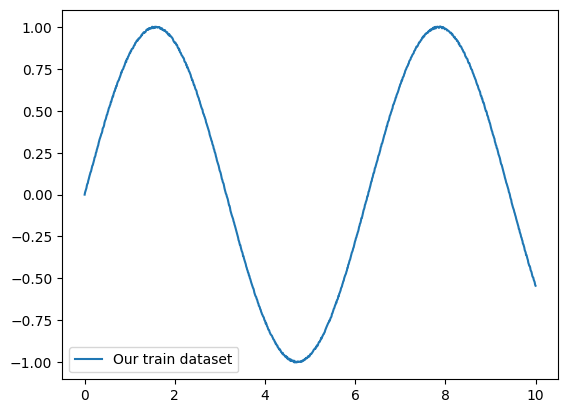

In [11]:
plt.plot(x, y, label = "Our train dataset")
plt.legend(loc = "best")
plt.show()

### Define an LSTM model

...

In [36]:
# Define the LSTM model
class LSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_states):
        h_state, c_state = hidden_states
        y, next_state = self.lstm(x, (h_state, c_state))
        h_state, c_state = next_state
        z = self.fc(y[:, -1, :])
        return z, h_state, c_state

In [37]:
# Define the model parameters
input_size = 1
hidden_size = 64
num_layers = 1
output_size = 1

#Create the model
model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
print(model)

LSTM(
  (lstm): LSTM(1, 64)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


### Trainer

...

In [38]:
def train(model, train_dataloader, num_epochs, lr):
    # Define the loss function and optimizer
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    
    # Training loop
    for epoch in range(num_epochs):
        # Training loss initialize
        train_loss = 0
        # Loop through batches
        for inputs, targets in train_dataloader:
            optimizer.zero_grad()
            # Initialize hidden states
            h_state = torch.zeros(num_layers, 1, hidden_size).to(device)
            c_state = torch.zeros(num_layers, 1, hidden_size).to(device)
            # Forward pass
            outputs, h_state, c_state = model(inputs.to(device), (h_state, c_state))
            loss = criterion(outputs, targets.to(device))
            train_loss += loss.item()
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
        
        # Compute final loss and display
        train_loss /= len(train_dataloader)
        print(f' Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}')
    
    # Return final hidden states
    return h_state, c_state

In [39]:
# Define the model parameters
input_size = 1
hidden_size = 64
num_layers = 2
output_size = 1
torch.manual_seed(12)
model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

# Train the model
num_epochs = 100
h_state, c_state = train(model, train_dataloader, num_epochs, lr = 1e-2)

 Epoch [1/100], Train Loss: 0.4449
 Epoch [2/100], Train Loss: 0.3834
 Epoch [3/100], Train Loss: 0.2451
 Epoch [4/100], Train Loss: 0.1251
 Epoch [5/100], Train Loss: 0.0950
 Epoch [6/100], Train Loss: 0.0877
 Epoch [7/100], Train Loss: 0.0451
 Epoch [8/100], Train Loss: 0.0230
 Epoch [9/100], Train Loss: 0.0121
 Epoch [10/100], Train Loss: 0.0137
 Epoch [11/100], Train Loss: 0.0062
 Epoch [12/100], Train Loss: 0.0054
 Epoch [13/100], Train Loss: 0.0052
 Epoch [14/100], Train Loss: 0.0031
 Epoch [15/100], Train Loss: 0.0036
 Epoch [16/100], Train Loss: 0.0039
 Epoch [17/100], Train Loss: 0.0031
 Epoch [18/100], Train Loss: 0.0016
 Epoch [19/100], Train Loss: 0.0018
 Epoch [20/100], Train Loss: 0.0020
 Epoch [21/100], Train Loss: 0.0021
 Epoch [22/100], Train Loss: 0.0032
 Epoch [23/100], Train Loss: 0.0024
 Epoch [24/100], Train Loss: 0.0011
 Epoch [25/100], Train Loss: 0.0010
 Epoch [26/100], Train Loss: 0.0005
 Epoch [27/100], Train Loss: 0.0006
 Epoch [28/100], Train Loss: 0.0006
 

### Evaluate model

...

In [48]:
def test_display(seed, dataloader, h_state, c_state, model, device):
    # Fetch a datapoint
    torch.manual_seed(seed)
    data = next(iter(train_dataloader))
    inputs_test = data[0]
    outputs_test = data[1]

    # Initialize hidden state and forward pass
    h_state.to(device)
    c_state.to(device)
    pred, h_state, c_state = model(inputs_test.to(device), (h_state, c_state))
    pred_display = pred.detach().cpu()
    print(pred_display.shape)
    
    # Display
    plt.scatter(inputs_test[:, 0], outputs_test[:, 0], c = "r", label = "Targets")
    plt.scatter(inputs_test[:, 0], pred_display[:, 0], c = "g", marker = "x", label = "Predictions")
    plt.legend(loc = "best")
    plt.ylim(-1.05, 1.05)
    plt.show()

torch.Size([32, 1])


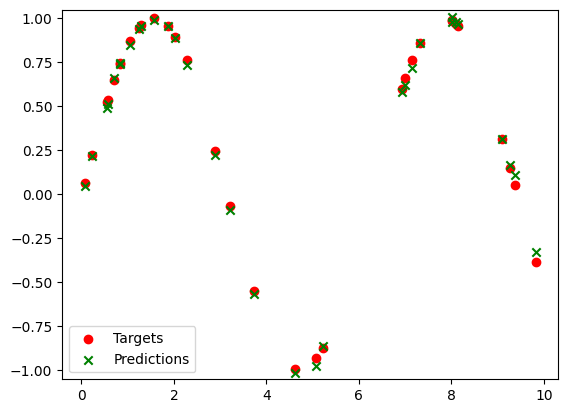

In [49]:
# Try it
test_display(seed = 5, dataloader = train_dataloader, h_state = h_state, c_state = c_state, model = model, device = device)

### What's next?

...